# Import and install requirements

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

directory = os.getcwd().split('/')[-1]

if directory == 'content':
    %cd drive/MyDrive/TDT17/notebooks


/content/drive/MyDrive/TDT17/notebooks


In [ ]:
!git clone https://github.com/ultralytics/yolov5  # clone

directory = os.getcwd().split('/')[-1]
if directory != 'yolov5':
  %cd yolov5

!pip install -qr requirements.txt
!pip install -U albumentations
!pip install wandb

import wandb
wandb.login()

fatal: destination path 'yolov5' already exists and is not an empty directory.
/content/drive/MyDrive/TDT17/notebooks/yolov5


In [ ]:
from yolov5 import utils
display = utils.notebook_init()  # checks

YOLOv5 🚀 v6.0-114-ga4207a2 torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)


Setup complete ✅


# Parse dataset

In [ ]:
directory = os.getcwd().split('/')[-1]
if directory == 'yolov5':
  %cd ../

directory = os.getcwd().split('/')[-1]
if directory == 'notebooks':
  %cd ../

merge_images = None
while merge_images != "y" or merge_images != "y":
  merge_images = input('Combine images to RGB? (y/n): ')

if merge_images:
  !python ./src/dataset_builder.py --merge
else: 
  !python ./src/dataset_builder.py

directory = os.getcwd().split('/')[-1]
if directory != 'notebooks':
  %cd ./notebooks/yolov5/

/content/drive/My Drive/TDT17/notebooks
/content/drive/My Drive/TDT17
Combine images to RGB? (y/n): y
Finished converting and merging: Video00000
Finished converting and merging: Video00001
Finished converting and merging: Video00002
Finished converting and merging: Video00003
Finished converting and merging: Video00009
Finished converting and merging: Video00010
Finished converting and merging: Video00011
Finished converting and merging: Video00017
Finished converting and merging: Video00018
/content/drive/My Drive/TDT17/notebooks/yolov5


In [ ]:
dataset_path = "all_videos_merged" if merge_images else "all_videos"

# Test labels

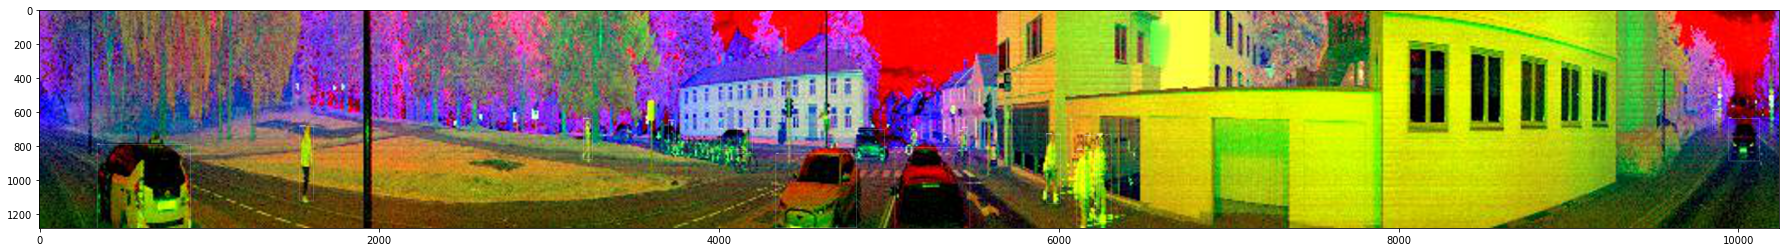

In [ ]:
import random
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
Image.MAX_IMAGE_PIXELS = None
plt.rcParams["figure.figsize"] = (40,4)

annotations = [os.path.join(f'../../data/{dataset_path}/labels', x) for x in os.listdir(f'../../data/{dataset_path}/labels') if x[-3:] == "txt"]

class_name_to_id_mapping = {"car": 0, "truck": 1, "bus": 2, "motorcycle": 3, "bicycle": 4, "scooter": 5, "person": 6, "rider": 7}

class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))

def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size
    
    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)))
        
        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))])
    
    plt.imshow(np.array(image))
    plt.show()

# Get any random annotation file 
annotation_file = random.choice(annotations)
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

#Get the corresponding image file
image_file = annotation_file.replace("labels", "images").replace("txt", "jpg")
assert os.path.exists(image_file)

image = Image.open(image_file)
# resize image and save
half = 10
image = image.resize( [int(half * s) for s in image.size] )

#Plot the Bounding Box
plot_bounding_box(image, annotation_list)

## Folder shortcuts

In [ ]:
data_folder = '../../data'
videos_folder = '../../videos'

In [ ]:
images_count = len(os.listdir(f'{data_folder}/{dataset_path}/images'))
labels_count = len(os.listdir(f'{data_folder}/{dataset_path}/labels'))
assert images_count == labels_count, 'images and labels count do not match'

# Split dataset



In [ ]:
from sklearn.model_selection import train_test_split
# Read images and annotations
images = [os.path.join(f'{data_folder}/{dataset_path}/images', x) for x in os.listdir(f'{data_folder}/{dataset_path}/images')]
annotations = [os.path.join(f'{data_folder}/{dataset_path}/labels', x) for x in os.listdir(f'{data_folder}/{dataset_path}/labels') if x[-3:] == "txt"]

images.sort()
annotations.sort()

# Split the dataset into train-valid-test splits 
train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.2, random_state = 1)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.5, random_state = 1)

In [ ]:
!mkdir ../../data/all_videos_split/ ../../data/all_videos_split/images ../../data/all_videos_split/labels ../../data/all_videos_split/images/train ../../data/all_videos_split/images/val ../../data/all_videos_split/images/test ../../data/all_videos_split/labels/train ../../data/all_videos_split/labels/val ../../data/all_videos_split/labels/test

In [ ]:
import shutil
#Utility function to move images 
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.copy(f, destination_folder)
        except:
            print(f)
            assert False

# Move the splits into their folders
move_files_to_folder(train_images, f'{data_folder}/all_videos_split/images/train')
move_files_to_folder(val_images, f'{data_folder}/all_videos_split/images/val')
move_files_to_folder(test_images, f'{data_folder}/all_videos_split/images/test')
move_files_to_folder(train_annotations, f'{data_folder}/all_videos_split/labels/train')
move_files_to_folder(val_annotations, f'{data_folder}/all_videos_split/labels/val')
move_files_to_folder(test_annotations, f'{data_folder}/all_videos_split/labels/test')

# Training

In [ ]:
!python train.py \ 
  --data {data_folder}/lidar.yaml \
  --cfg yolov5s.yaml \
  --weights yolov5s.pt \
  --img 1024 \
  --batch 16 \
  --epochs 15 \
  --project tdt17-yolo-ai-gutta \
  --upload_dataset \
  --bbox_interval 1 \
  --save-period 1

train: weights=, cfg=yolov5s.yaml, data=../../data/lidar.yaml, hyp=data/hyps/hyp.scratch.yaml, epochs=3, batch_size=16, imgsz=1024, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=0, save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 2021-11-30 torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0, translate=0.1, scale=0.5,

# Prediction

## Get latest run

In [ ]:
runs = sorted(os.listdir('./runs/train'), reverse=True)
latest_run = runs[0]

In [ ]:
!mkdir ../../detection_runs ../../detection_runs/baseline ../../detection_runs/improved

In [ ]:
video_files = sorted(os.listdir(videos_folder))

## Create a baseline

In [ ]:
for file in video_files:
    !python detect.py 
        --source {videos_folder}/{file}
        --weights yolov5s.pt \
        --project ../../detection_runs/baseline \

## Run detection with improved weights

In [ ]:
for file in video_files:
    !python detect.py 
        --source {videos_folder}/{file}
        --weights runs/train/{latest_run}/weights/best.pt \
        --project ../../detection_runs/improved \

detect: weights=['runs/train/exp17/weights/best.pt'], source=../../videos/Video00002_intensity.avi, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.0-96-g8df64a9 torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)

Fusing layers... 
Model Summary: 213 layers, 7031701 parameters, 0 gradients, 15.9 GFLOPs
video 1/1 (1/101) /content/drive/.shortcut-targets-by-id/11shDSuoKPHgKQXUvJaF__RLTgR5ZGRrg/TDT17-object-detection-project/videos/Video00002_intensity.avi: 96x640 Done. (0.021s)
video 1/1 (2/101) /content/drive/.shortcut-targets-by-id/11shDSuoKPHgKQXUvJaF__RLTgR5ZGRrg/TDT17-object-detection-project/videos/Video00002_intensity.avi: 96x640 Done. (0.018s)
video 1/1 (3/101) /conte